In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [7]:
# === CONFIG ===
DATA_DIR = 'pre_process_data'
IMG_SIZE = (244, 244)
BATCH_SIZE = 32
EPOCHS = 100

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 578 images belonging to 9 classes.


In [10]:
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 138 images belonging to 9 classes.


In [11]:
num_classes = len(train_generator.class_indices)

In [12]:
# === TRANSFER LEARNING MODEL ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = True  # Unfreeze base model

C:\Users\janit\AppData\Local\Temp\ipykernel_1388\2459462940.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 42s 4us/step


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 244, 244, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 122, 122, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 122, 122, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 122, 122, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 122, 122, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 122, 122, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 122, 122, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 122, 122, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 122, 122, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 122, 122, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 122, 122, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 122, 122, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 123, 123, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 61, 61, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 2,235,401 (8.53 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [17]:
# === TRAIN ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/100


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.2005 - loss: 2.3163 - val_accuracy: 0.2174 - val_loss: 2.7384
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.6236 - loss: 1.1314 - val_accuracy: 0.2246 - val_loss: 2.7205
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.7843 - loss: 0.6986 - val_accuracy: 0.2826 - val_loss: 2.5385
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8811 - loss: 0.4585 - val_accuracy: 0.3261 - val_loss: 2.4363
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9180 - loss: 0.3399 - val_accuracy: 0.3913 - val_loss: 2.4046
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9449 - loss: 0.2485 - val_accuracy: 0.3841 - val_loss: 2.3270
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.8916 - loss: 0.3723 - val_accuracy: 0.4710 - val_loss: 2.1376
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.9536 - loss: 0.1944 - val_accuracy: 0.4275 - val_loss: 2.

In [30]:
# === UNFREEZE SOME LAYERS TO FINE-TUNE ===
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Fine-tune last 50 layers
    layer.trainable = False
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9710 - val_loss: 0.1509
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9976 - loss: 0.0119 - val_accuracy: 0.9855 - val_loss: 0.0794
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9972 - loss: 0.0174 - val_accuracy: 0.9783 - val_loss: 0.0993
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9942 - loss: 0.0189 - val_accuracy: 0.9855 - val_loss: 0.0949
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9972 - loss: 0.0119 - val_accuracy: 0.9710 - val_loss: 0.0943
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9940 - loss: 0.0199 - val_accuracy: 0.9783 - val_loss: 0.0954
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 1.0000 - loss: 0.0109 - val_accuracy: 0.9928 - val_loss: 0.0515
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9993 - loss: 0.0060 - val_accuracy: 0.9855 - val_loss:

In [31]:
# === SAVE MODEL ===
model.save('model_transfer_learning.h5')

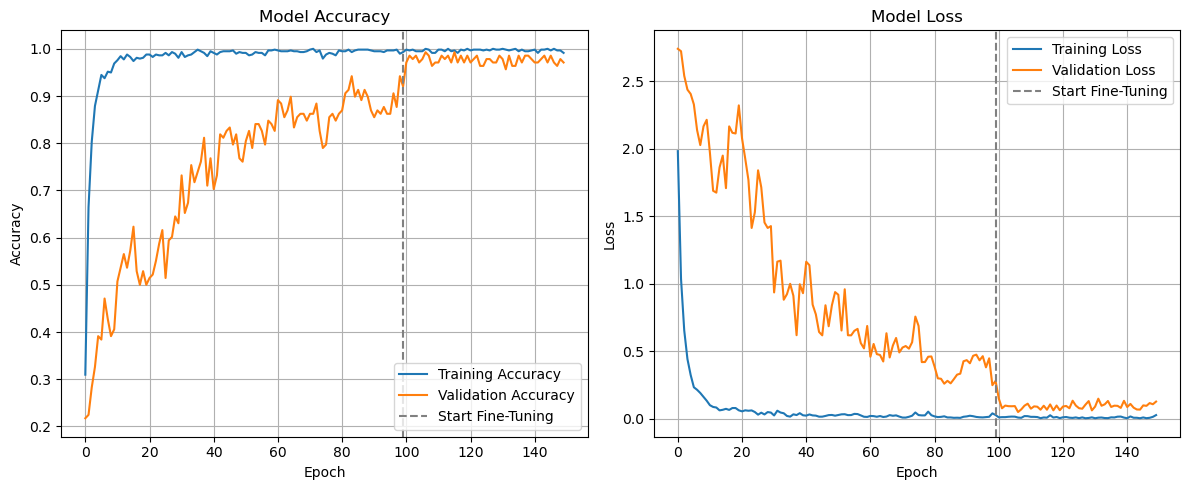

In [34]:
import matplotlib.pyplot as plt

# Combine metrics from both training phases
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']
loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

total_epochs = len(acc)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [35]:
from tensorflow.keras.models import load_model

model = load_model('model_transfer_learning.h5')  # or 'best_model.h5' if using checkpointing

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (244, 244)
BATCH_SIZE = 32

# 30% test split (technically called "validation" here)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

# Test (validation) generator (30% of data)
test_generator = datagen.flow_from_directory(
    'pre_process_data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 210 images belonging to 9 classes.


In [38]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.9818 - loss: 0.0505
Test Accuracy: 98.10%
Test Loss: 0.0747


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step
              precision    recall  f1-score   support

        CROW       0.98      0.98      0.98        51
         DOG       0.98      1.00      0.99        59
  FILLED_POT       1.00      1.00      1.00         2
        MOON       1.00      0.90      0.95        20
 PALMYRA_FAN       1.00      1.00      1.00         2
   Punkalasa       1.00      1.00      1.00        16
       SNAKE       1.00      1.00      1.00         6
         SUN       0.94      1.00      0.97        33
   Watapatha       1.00      0.95      0.98        21

    accuracy                           0.98       210
   macro avg       0.99      0.98      0.99       210
weighted avg       0.98      0.98      0.98       210



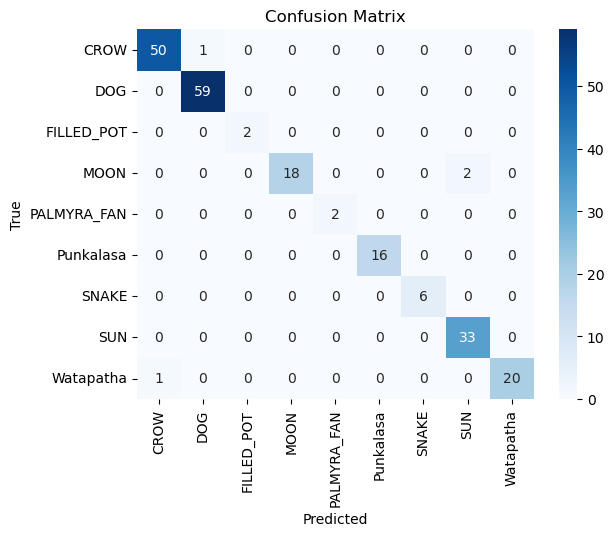

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()